In [1]:
import pandas as pd
from pathlib import Path

In [6]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'GPU' or 'CPU' and make it uppercase
    _, implementation, n_docs, n_queries, iteration = parts
    
    # Read execution time from file
    execution_time = None
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    if execution_time is None:
        print(f"Failed to parse execution time in {file_path}")
        return None
    return dict(implementation=implementation.upper(), n_docs=n_docs, n_queries=n_queries, execution_time=execution_time, iteration=iteration)

In [7]:
# Collect all txt files matching the pattern
files = Path('../results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [item for item in [extract_information(file) for file in files] if item]
df = pd.DataFrame.from_records(data)

print(df)

Failed to parse execution time in ../results/out-cpu-2-10000-1000.txt
Failed to parse execution time in ../results/out-cpu-1-10000-1000.txt
Failed to parse execution time in ../results/out-cpu-3-10000-1000.txt
   implementation n_docs n_queries  execution_time iteration
0             GPU  10000      1000       30640.427         3
1             CPU     10        10           1.254         1
2             GPU  10000       100         258.558         3
3             GPU     10        10         220.958         2
4             GPU   1000        10         229.277         1
5             GPU   1000       100         230.312         1
6             CPU  10000       100        5579.856         1
7             CPU     10        10           0.924         3
8             CPU    100        10          10.908         3
9             CPU  10000        10         540.524         2
10            GPU     10        10         230.525         1
11            GPU  10000       100         258.822        

In [8]:
df.sort_values(by=['implementation', 'n_docs', 'n_queries'])

,implementation,n_docs,n_queries,execution_time,iteration
1,CPU,10,10,1.254,1
7,CPU,10,10,0.924,3
19,CPU,10,10,0.935,2
8,CPU,100,10,10.908,3
21,CPU,100,10,10.966,2
36,CPU,100,10,10.497,1
40,CPU,100,100,69.610,1
43,CPU,100,100,68.769,3
51,CPU,100,100,69.043,2
23,CPU,1000,10,56.054,1


In [10]:
agg_df = (
    df[['implementation', 'n_docs', 'n_queries', 'execution_time']]
        .groupby(['implementation', 'n_docs', 'n_queries'])
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df.head()

,implementation,n_docs,n_queries,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,10,1.037667,0.924,1.254,0.187431
1,CPU,100,10,10.790333,10.497,10.966,0.255684
2,CPU,100,100,69.140667,68.769,69.610,0.428922
3,CPU,1000,10,61.603667,56.054,64.721,4.818341
4,CPU,1000,100,560.410667,558.825,563.265,2.477001


In [11]:
cpu_df = agg_df[agg_df['implementation']=='CPU'].copy()
gpu_df = agg_df[agg_df['implementation']=='GPU'].copy()

In [13]:
agg_df

,implementation,n_docs,n_queries,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,10,1.037667,0.924,1.254,0.187431
1,CPU,100,10,10.790333,10.497,10.966,0.255684
2,CPU,100,100,69.140667,68.769,69.610,0.428922
3,CPU,1000,10,61.603667,56.054,64.721,4.818341
4,CPU,1000,100,560.410667,558.825,563.265,2.477001
5,CPU,1000,1000,5372.535333,5307.022,5434.038,63.602910
6,CPU,10000,,255.333667,251.123,263.205,6.822319
7,CPU,10000,10,548.937333,540.524,553.348,7.289016
8,CPU,10000,100,5509.822000,5389.533,5579.856,104.641697
9,GPU,10,10,229.286000,220.958,236.375,7.782822


TypeError: must be real number, not str

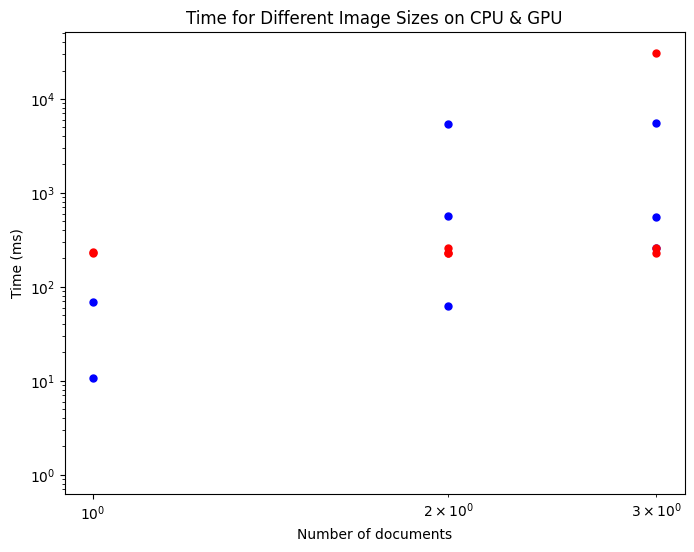

In [12]:
import math
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(cpu_df['n_docs'], cpu_df['mean_execution_time'], label='CPU', marker='.', s=100, c='blue')

ax.scatter(gpu_df['n_docs'], gpu_df['mean_execution_time'], label="GPU", marker='.', s=100, c='red')

ax.set_title('Time for Different Image Sizes on CPU & GPU')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Number of documents')
ax.set_xscale("log")
ax.set_yscale("log")
plt.xticks(cpu_df['n_docs'], labels=[f"$2^{{{int(math.log(n_inp_element, 2))}}}$" for n_inp_element in cpu_df['n_docs'].values])
ax.legend()

plt.show()